In [1]:
import tensorflow as tf
import keras
import numpy as np
import math

Using TensorFlow backend.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

<Figure size 640x480 with 2 Axes>

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

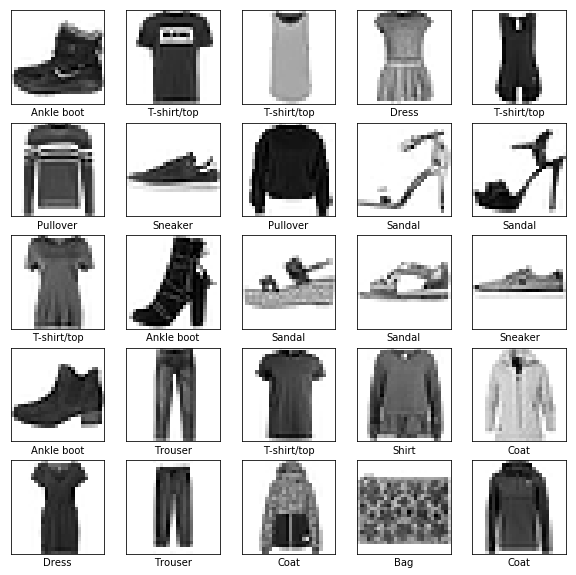

In [6]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(10, activation='softmax')
])

# model = tf.keras.Sequential()
# # Must define the input shape in the first layer of the neural networ
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(10, activation='softmax'))
# # Take a look at the model summary
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def getSecret(image):
    return np.unpackbits(np.array(image.flatten(), np.uint8))

In [9]:
def bin2str(bs):
    secret_string = ''.join(str(x) for x in bs)
    return secret_string

def bitToLabel(bits, label_num):
    x = math.ceil(len(bits)/label_num)
    label = [0]*x
    for i in range(x):
        label[i] = int(bits[i*label_num:(i+1)*label_num], 2)
    return label

def labelToBit(label, label_num):
    strv = ""
    for l in label:
        temp = bin(l).replace('0b','')
#         strv += temp
        pad = label_num - len(temp)
        strv += pad * "0" + temp
    return strv

def str2bin(strv):
    return np.array([int(c) for c in strv])

In [31]:
def getPrimeList(len):   
    list=[]
    i=2
    for i in range (2,len):
        j=2
        for j in range(2,i):
            if(i%j==0):
                break
        else:
            list.append(i)
    return list


def genMal(length, shape = (28, 28), force = 10):
    mal_x = np.zeros((length, shape[0], shape[1]))
    p_list = getPrimeList(force)
    for i in range(length):
        round = int((i / (28 * 28)) + 1)
#         print(int(i/28) - round + 1)
#         mal_x[i, int((i%(28*28))/28) - round + 1, i%28] = round * 3;
#         mal_x[i, int(((i+3)%(28*28))/28) - round + 1, (i+3)%28] = round * 5;
#         mal_x[i, int(((i+5)%(28*28))/28) - round + 1, (i+5)%28] = round * 7;
#         mal_x[i, int(((i+11)%(28*28))/28) - round + 1, (i+11)%28] = round * 11;
#         mal_x[i, int(((i+13)%(28*28))/28) - round + 1, (i+13)%28] = round * 13;
#         mal_x[i, int(((i+17)%(28*28))/28) - round + 1, (i+17)%28] = round * 17;
        for p in p_list:
            mal_x[i, int(((i + p)%(28*28))/28) - round + 1, (i+p) % 28] = round * p
        
    return mal_x

def duplicate(x_mal, y_mal, d = 10):
    x = x_mal
    y = y_mal
    for i in range(d):
        x_mal = np.vstack((x, x_mal))
        y_mal = np.hstack((y, y_mal))
    return x_mal, y_mal

def augumentAttack(x_train, y_train, start = 0, size = 1):
    secret_image = x_train[start:start+size]
    showImg(secret_image)
    secret_image_int = img_as_ubyte(secret_image)
    s = getSecret(secret_image_int)

    max_bit_size = math.floor(math.log(len(class_names), 2))
    transformed_s = bitToLabel(bin2str(s), max_bit_size)

    x_mal = genMal(len(transformed_s))
    y_mal = np.array(transformed_s)
    
    d_x_mal, d_y_mal = duplicate(x_mal, y_mal)
    x_new = np.vstack((x_train, d_x_mal))

    y_new = np.hstack((y_train, d_y_mal))
    
    secret_lenght = len(transformed_s)
    
    return x_new, y_new, secret_lenght

In [11]:
from skimage import img_as_ubyte
def showImg(img):
    plt.figure()
    if(len(img.shape) > 2):
        for i in range(img.shape[0]):
            I = img[i]
            plt.subplot(1,img.shape[0]+1,i+1)
            plt.imshow(I)
    else:
        plt.imshow(img)
    plt.grid(False)
    plt.show()

In [34]:
def decode(s, shape = (28, 28)):
    # convert binary to decimals
    decimals = np.packbits(s);
    print(decimals.shape)
    return decimals.reshape((-1, shape[0], shape[1]))

## attack begins at here

secret_num indicate the number of image you want to steal

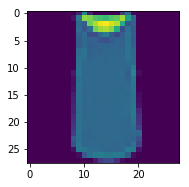

D:\download\Programming_language\python\anaconda\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [32]:
secret_num = 1
x_new, y_new, secret_length = augumentAttack(x_train, y_train, 2, secret_num)

In [ ]:
## train malicious model

by increaseing epochs of training m

In [33]:
test_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(20, activation='softmax')
])

test_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

test_model.fit(x_new,
         y_new,
         batch_size=128,
         epochs=20)

Epoch 1/20
83001/83001 [==============================] - 3s 31us/step - loss: 0.6744 - acc: 0.7704
Epoch 2/20
83001/83001 [==============================] - 2s 26us/step - loss: 0.4670 - acc: 0.8175
Epoch 3/20
83001/83001 [==============================] - 2s 26us/step - loss: 0.4233 - acc: 0.8325
Epoch 4/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.3935 - acc: 0.8415
Epoch 5/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.3704 - acc: 0.8507
Epoch 6/20
83001/83001 [==============================] - 2s 27us/step - loss: 0.3523 - acc: 0.8573
Epoch 7/20
83001/83001 [==============================] - 2s 29us/step - loss: 0.3317 - acc: 0.8667
Epoch 8/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3173 - acc: 0.8731
Epoch 9/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.3015 - acc: 0.8803
Epoch 10/20
83001/83001 [==============================] - 2s 28us/step - loss: 0.2868 - acc: 0.8885

2091
6272
(784,)


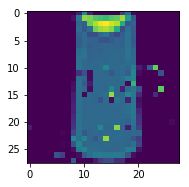

In [35]:
x_mal = genMal(secret_length)
max_bit_size = math.floor(math.log(len(class_names), 2))
y_pred = np.argmax(test_model.predict(x_mal), axis = 1)

print(len(y_pred))

strv = labelToBit(y_pred, max_bit_size)[:secret_num*6272]

print(len(strv))
test_s = str2bin(strv)
ds = decode(test_s)
showImg(ds)

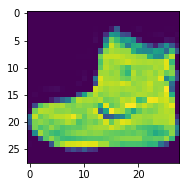


Test accuracy: 0.8868


In [36]:
secret_img = x_train[0:secret_num]
showImg(secret_img)

test_loss, test_acc = test_model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=10)
#          validation_data=(x_valid, y_valid),
#          callbacks=[checkpointer])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

## this part is for image compression

1. DCT transformation
2. quantilization
2. zig-zag scan

need to be done

In [ ]:
def load_quantization_table():
    # Quantization Table for: Photoshop - (Save For Web 080)
    q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                  [2, 2, 2, 2, 3, 4, 5, 6],
                  [2, 2, 2, 2, 4, 5, 7, 9],
                  [2, 2, 2, 4, 5, 7, 9, 12],
                  [3, 3, 4, 5, 8, 10, 12, 12],
                  [4, 4, 5, 7, 10, 12, 12, 12],
                  [5, 5, 7, 9, 12, 12, 12, 12],
                  [6, 6, 9, 12, 12, 12, 12, 12]])
    return q



In [ ]:
print(load_quantization_table)

In [ ]:
from scipy import fftpack
def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')

def quantize(block, q):
    return (block / q).round().astype(np.int32)

def padding(img):
    rows, cols = img.shape
    if rows % 8 != 0 or cols % 8 != 0:
        dct_rows = rows + 8 - rows % 8
        dct_cols = cols + 8 - cols % 8
        diff_cols = dct_cols - cols
        diff_rows = dct_rows - rows
#         npmat = np.pad(img,((0,diff_rows), (0,diff_cols),(0,0)), mode = 'mean')
        blocks_count = (dct_rows // 8)*(dct_cols // 8)
        new_img = y = np.pad(img, (0, diff_cols), 'constant')
    return new_img

def block_to_zigzag(block):
    return np.array([block[point] for point in  (*block.shape)])

def block_dct(img):
    rows, cols = img.shape
    r_count = int(rows/8)
    c_count = int(cols/8)
    for i in range(r_count):
        for j in range(c_count):
            block = img[i*8:(i+1)*8, j*8:(j+1)*8]
            print(block)
            new_block = dct_2d(block)
            quant_block = quantize(new_block, load_quantization_table())
            msg = block_to_zigzag(quant_block)
            print(msg)
            
    
secret_image_int = img_as_ubyte(secret_image)
# print(secret_image_int)
new_img = padding(secret_image_int)
print(new_img.shape)
block_dct(new_img)

In [ ]:
x = np.ones((2, 2)) * 5
print(x)
y = np.pad(x, (0, 2), 'wrap')
print(y)

In [ ]:
matrix = np.random.random((14,14))
for x in range(14):
    for y in range(14):
        matrix[x][y] = int(matrix[x][y]*10)
print(matrix)

In [ ]:
y = np.pad(matrix, (0, 2), 'constant')